# Временные ряды: Спрогнозировать количество заказов такси на следующий час

## Описание проекта

Компания «Такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

- Построим модель для такого предсказания.

- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План по выполнению проекта

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10 % от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка данных

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

Загрузим данные из файла в переменную

In [ ]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [ ]:
print('\nВывод данных из таблицы')
data


Вывод данных из таблицы


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Выведем для просмотра информацию о датасете

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


- Имеем 26496 наблюдений и два признака: дата/время (сделали индексом), количество заказов

Посмотрим на графике распределение заказов во времени

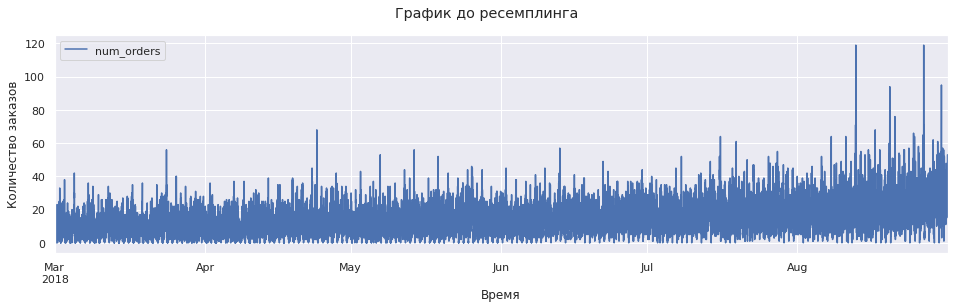

In [ ]:
data.plot(figsize = (16, 4))
plt.suptitle('График до ресемплинга')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

### Произведем ресеплинг размером 1 час

In [ ]:
data = data.resample('1H').sum()

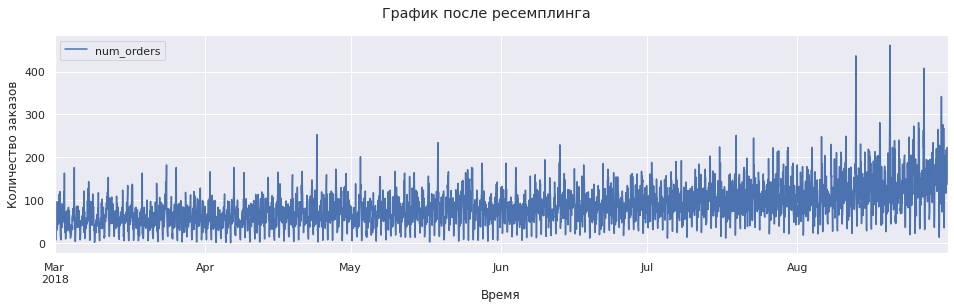

In [ ]:
data.plot(figsize = (16, 4))
plt.suptitle('График после ресемплинга')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

In [ ]:
print('Наблюдений после ресемплинга: ', data.shape)

Наблюдений после ресемплинга:  (4416, 1)


# 2. Анализ данных

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

In [ ]:
data['rolling_mean'] = data['num_orders'].shift().rolling(10).mean()

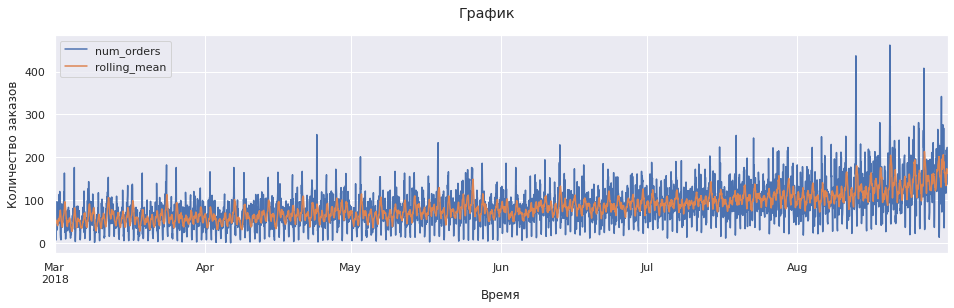

In [ ]:
data[['num_orders', 'rolling_mean']].plot(figsize = (16, 4))
plt.suptitle('График')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

#### Обратим внимание, что количество заказов увеличивается в сезон летних отпусков

### Месячные колебания

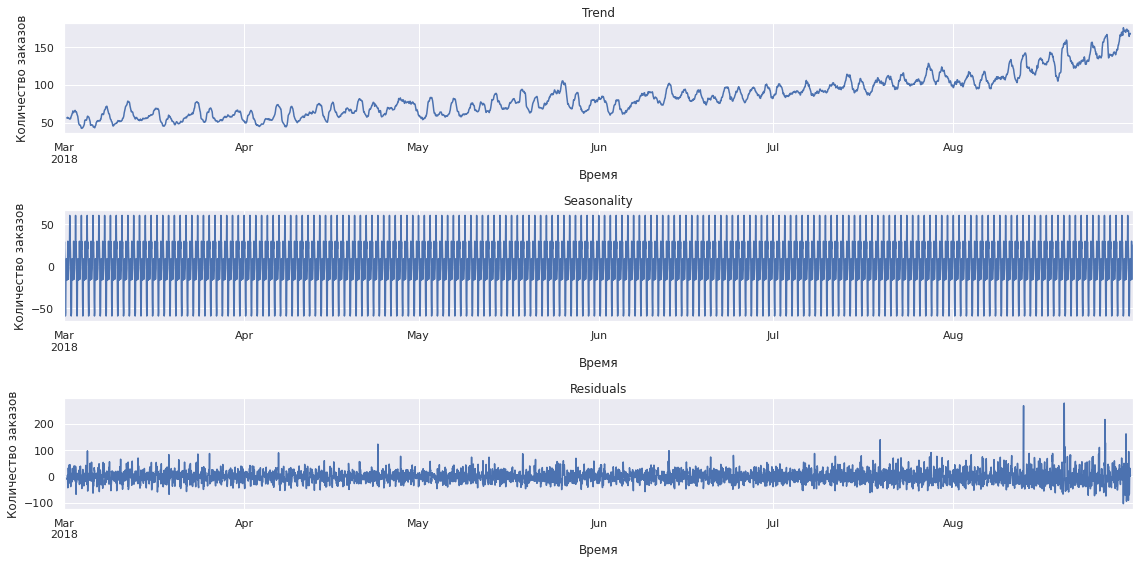

In [ ]:
data = data.fillna(0)
decomposed = seasonal_decompose(data)
plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend['num_orders'].plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['num_orders'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid['num_orders'].plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.show()

### Дневные колебания

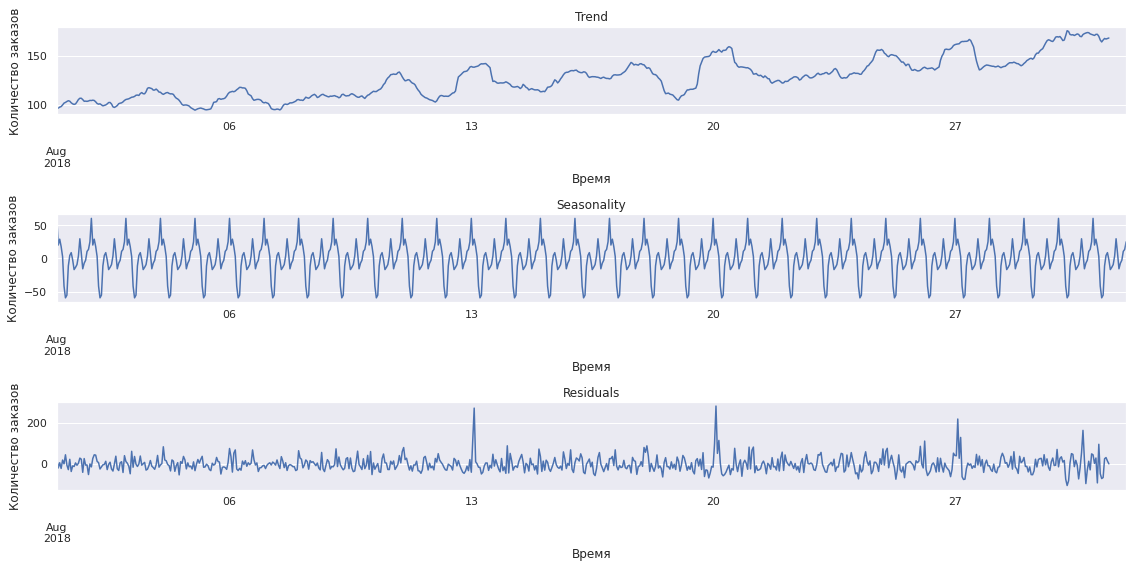

In [ ]:
data = data.fillna(0)
decomposed = seasonal_decompose(data)
plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend['num_orders']['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['num_orders']['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid['num_orders']['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.show()

### Часовые колебания

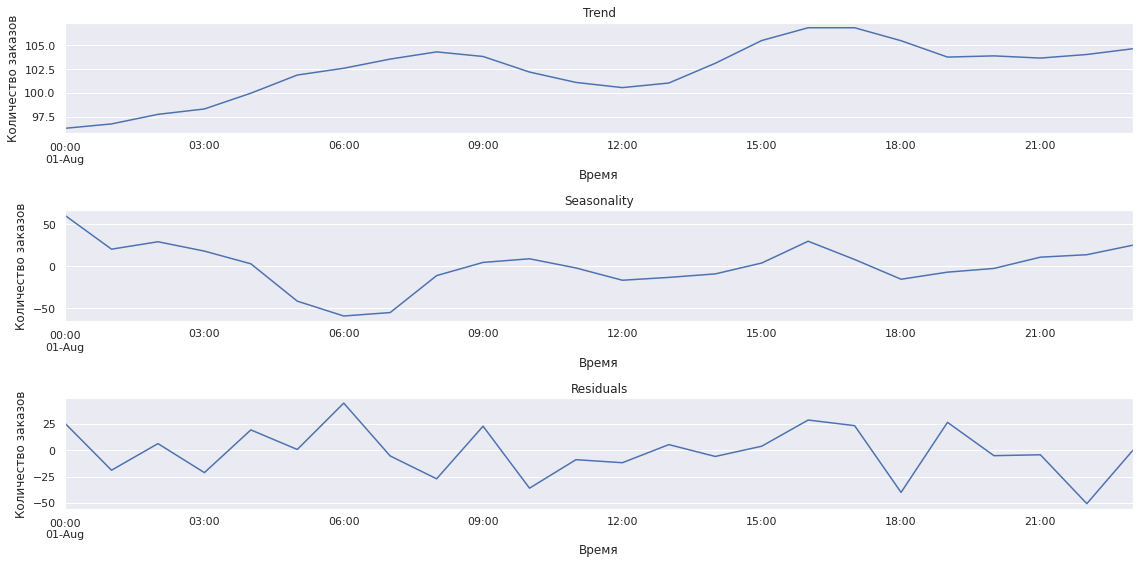

In [ ]:
data = data.fillna(0)
decomposed = seasonal_decompose(data)
plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend['num_orders']['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['num_orders']['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid['num_orders']['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.show()

**Вывод**
- Тренд: количесвто заказов растет с марта по август, в течении каждого месяца, в течении дня
- Сезонность: в течение недели пик заказов приходиться на понедельник, в течение суток количество заказов снижается с 5 до 7 часов утра и максимально повышается около полуночи.

### Чтобы ряд сделать стационарным, найдём разности его значений.

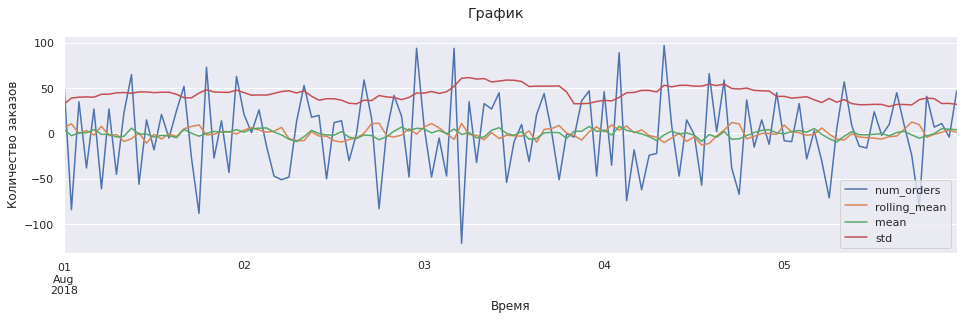

In [ ]:
data = data - data.shift()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data['2018-08-01':'2018-08-05'].plot(figsize = (16, 4))
# data.plot(figsize = (16, 4))
plt.suptitle('График')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

**Вывод** 

Ряд стал более стационарным, значит данные можно прогнозировать.

# 3. Подготовка признаков

### Создадим признаки для горизонта прогнозирования в один шаг.


Не все факторы подходят, чисто логически, для прогнозирования на следующий час.

1) Фактор год: НЕТ, однозначно не подходит. Мы имеем данные меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: НЕТ, аналогично году, у нас в истории всего один март, апрель, май ...<br>
3) Фактор день: НЕТ, также не подходит, будет просто последовательность чисел.<br>
4) Фактор день недели: ДА, т.к. у нас есть недельная сезонность.<br>
5) Фактор час: ДА, т.к. есть часовая (суточная) сезонность.<br>
6) Фактор lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.<br>
7) Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда. <br>

Так как мы предсказываем количество заказов на следующий час, то надо использовать календарные признаки день недели и час суток.

- Прибавим к таблице календарные признаки: день недели, час суток. Нам необходимо сделать предсказания на следущий час, поэтому будем использовать календарные признаки: день недели, час суток.
- Вычислим отстающие значения max_lag, добавим как признак.
- Вычислим скользящее среднее и добавим его как признак.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 100, 10)
print(data.head())

                     num_orders  rolling_mean  mean  ...  lag_98  lag_99  lag_100
datetime                                             ...                         
2018-03-01 00:00:00         NaN           NaN   NaN  ...     NaN     NaN      NaN
2018-03-01 01:00:00       -39.0           NaN   NaN  ...     NaN     NaN      NaN
2018-03-01 02:00:00       -14.0           NaN   NaN  ...     NaN     NaN      NaN
2018-03-01 03:00:00        -5.0           NaN   NaN  ...     NaN     NaN      NaN
2018-03-01 04:00:00       -23.0           NaN   NaN  ...     NaN     NaN      NaN

[5 rows x 106 columns]


### Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 8 : 1 : 1

In [ ]:
train, valid_test = train_test_split(data, shuffle = False, test_size = 0.2) # Обязательно без перемешивания данных shuffle = False. Так как время упорядоченные данные.
valid, test = train_test_split(valid_test, shuffle = False, test_size = 0.5)
train = train.dropna()
print('Проверим последовательность разделения данных на выборки')
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

Проверим последовательность разделения данных на выборки
2018-03-05 05:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


### Выделим признаки и целевой признак

In [ ]:
features_train = train.drop(['mean', 'std', 'num_orders'], axis = 1)
features_valid = valid.drop(['mean', 'std', 'num_orders'], axis = 1)
features_test = test.drop(['mean', 'std', 'num_orders'], axis = 1)
target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']
print('Размер обучающей выборки', features_train.shape)
print('Размер валидационной выборки', features_valid.shape)
print('Размер тестовой выборки', features_test.shape)
print('Размер целевого признака трейн', target_train.shape)
print('Размер целевого признака валид', target_valid.shape)
print('Размер целевого признака тест', target_test.shape)

Размер обучающей выборки (3431, 103)
Размер валидационной выборки (442, 103)
Размер тестовой выборки (442, 103)
Размер целевого признака трейн (3431,)
Размер целевого признака валид (442,)
Размер целевого признака тест (442,)


# 4. Обучение моделей

In [ ]:
# Функция расчета метрики RMSE (root mean squared error)
def make_rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred)**0.5, 2)

## LinearRegression

In [ ]:
%%time
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(features_train, target_train)

print("RMSE обучающей выборки:", make_rmse(model_LinearRegression.predict(features_train), target_train))
print("RMSE валидационной выборки: ", make_rmse(model_LinearRegression.predict(features_valid), target_valid))

RMSE обучающей выборки: 21.09
RMSE валидационной выборки:  29.82
CPU times: user 57.8 ms, sys: 27.7 ms, total: 85.5 ms
Wall time: 67.2 ms


**Вывод:** 

Модель LinearRegression RMSE валидационной выборки:  29.8

## RandomForestRegressor

Произведём подбор гиперпараметров для модели при помощи GridSearchCV

In [ ]:
%%time
clf = RandomForestRegressor(random_state = 42, n_jobs = -1)

parameter_grid = {
            'max_depth': [10, 50],
            'n_estimators': [500, 1000]  
        }

grid_searcher = GridSearchCV(clf, parameter_grid, verbose=10, n_jobs = -1)
grid_searcher.fit(features_train, target_train)
clf_best = grid_searcher.best_estimator_
 
print('Best params = ', clf_best)

Best params =  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

CPU times: user 3min 54s, sys: 1.42 s, total: 3min 56s

Wall time: 31min 31s

In [ ]:
%%time
model_RandomForestRegressor = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs= -1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
model_RandomForestRegressor.fit(features_train, target_train)
print("RMSE обучающей выборки:", make_rmse(model_RandomForestRegressor.predict(features_train), target_train))
print("RMSE валидационной выборки: ", make_rmse(model_RandomForestRegressor.predict(features_valid), target_valid))

RMSE обучающей выборки: 8.8
RMSE валидационной выборки:  35.51
CPU times: user 4min 48s, sys: 939 ms, total: 4min 49s
Wall time: 2min 27s


**Вывод:**

- Модель RandomForestRegressor RMSE валидационной выборки:  35.5

## LGBMRegressor

In [ ]:
%%time
clf = LGBMRegressor(random_state = 42, n_jobs = -1)

parameter_grid = {
            'max_depth': [1, 5, 10, 50],
            'n_estimators': [1500, 3000],
            'learning_rate' : [0.01, 0.001]
        }

grid_searcher = GridSearchCV(clf, parameter_grid, verbose = True,  n_jobs = -1)
grid_searcher.fit(features_train, target_train)
clf_best = grid_searcher.best_estimator_
 
print('Best params = ', clf_best)

Best params =  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

CPU times: user 1min 6s, sys: 1.03 s, total: 1min 7s

Wall time: 22min 6s

In [ ]:
%%time
model_LGBMRegressor = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model_LGBMRegressor.fit(features_train, target_train)
print("RMSE обучающей выборки:", make_rmse(model_LGBMRegressor.predict(features_train), target_train))
print("RMSE валидационной выборки: ", make_rmse(model_LGBMRegressor.predict(features_valid), target_valid))

RMSE обучающей выборки: 2.46
RMSE валидационной выборки:  33.3
CPU times: user 55.2 s, sys: 478 ms, total: 55.7 s
Wall time: 28.4 s


**Вывод:** 
- Модель LGBMRegressor RMSE валидационной выборки:  33.29

## CatBoostRegressor

In [ ]:
%%time
clf = CatBoostRegressor(
    task_type= 'GPU', 
    random_state = 42
    )

parameter_grid = {'learning_rate': [0.03, 0.1],
                  'depth': [4, 6, 10],
                  'l2_leaf_reg': [1, 3]}


grid_searcher = GridSearchCV(clf, parameter_grid, verbose = True, n_jobs = -1)
grid_searcher.fit(features_train, target_train)
 
print('Best estimator = ', grid_searcher.best_estimator_)
print('Best params = ', grid_searcher.best_params_)
print('Best score = ', grid_searcher.best_score_)

- Best estimator =  <catboost.core.CatBoostRegressor object at 0x7f6792890c10>
- Best params =  {'depth': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
Best score =  0.5510070132732838


CPU times: user 1min 49s, sys: 21 s, total: 2min 10s
Wall time: 42min 23s

In [ ]:
%%time
model_CatBoostRegressor = CatBoostRegressor(task_type= 'GPU',
                                            max_depth = 10,
                                            l2_leaf_reg = 3,
                                            learning_rate = 0.03,
                                            random_state = 42, verbose = False)
model_CatBoostRegressor.fit(features_train, target_train)
print("RMSE обучающей выборки:", make_rmse(model_CatBoostRegressor.predict(features_train), target_train))
print("RMSE валидационной выборки: ", make_rmse(model_CatBoostRegressor.predict(features_valid), target_valid))

RMSE обучающей выборки: 12.82
RMSE валидационной выборки:  33.68
CPU times: user 2min 9s, sys: 5.96 s, total: 2min 15s
Wall time: 2min 8s


**Вывод:** 

Модель CatBoostRegressor RMSE валидационной выборки:  33.6

## XGBoostRegressor

In [ ]:
%%time
model = XGBRegressor(tree_method='gpu_hist', gpu_id=0, n_jobs= -1, random_state=42)

parameter_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [-1, 5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 1000]
              }

grid_searcher = GridSearchCV(model, parameter_grid, verbose = True, n_jobs = -1)
grid_searcher.fit(features_train, target_train)
 
print('Best params = ', grid_searcher.best_estimator_)

Best params =  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=4, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, tree_method='gpu_hist', verbosity=1)

CPU times: user 3.95 s, sys: 232 ms, total: 4.18 s

Wall time: 3min 35s

In [ ]:
%%time
model_XGBRegressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=4, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, tree_method='gpu_hist', verbosity=1)
model_XGBRegressor.fit(features_train, target_train)
print("RMSE обучающей выборки:", make_rmse(model_XGBRegressor.predict(features_train), target_train))
print("RMSE валидационной выборки: ", make_rmse(model_XGBRegressor.predict(features_valid), target_valid))

RMSE обучающей выборки: 4.87
RMSE валидационной выборки:  33.02
CPU times: user 9.92 s, sys: 142 ms, total: 10.1 s
Wall time: 9.77 s


**Вывод:** 

Модель XGBRegressor RMSE валидационной выборки:  33.02


### Сравним результаты метрики RMSE обученных моделей

<table>
    <tr><th>Модель</th><th>RMSE</th></tr>
    <tr><td>LinearRegression</td><td>29.8</td></tr>
    <tr><td>RandomForestRegressor</td><td>35.5</td></tr>
    <tr><td>LGBMRegressor</td><td>33.3</td></tr>
    <tr><td>CatBoostRegressor</td><td>33.6</td></tr>
    <tr><td>XGBRegressor</td><td>33.0</td></tr>
</table>

Наилучший результат получили на модели LinearRegression. Её будем использовать на тестировании

# 5. Тестирование модели

In [ ]:
%%time
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(features_train, target_train)
predicted_test = model_LinearRegression.predict(features_test)
print("RMSE тестовой выборки: ", make_rmse(predicted_test, target_test))

RMSE тестовой выборки:  40.0
CPU times: user 51.4 ms, sys: 13.1 ms, total: 64.4 ms
Wall time: 38.8 ms


**Вывод:**
- RMSE на тестовой выборки:  40

Построим график сравнения количества заказов фактических и предсказанных. 

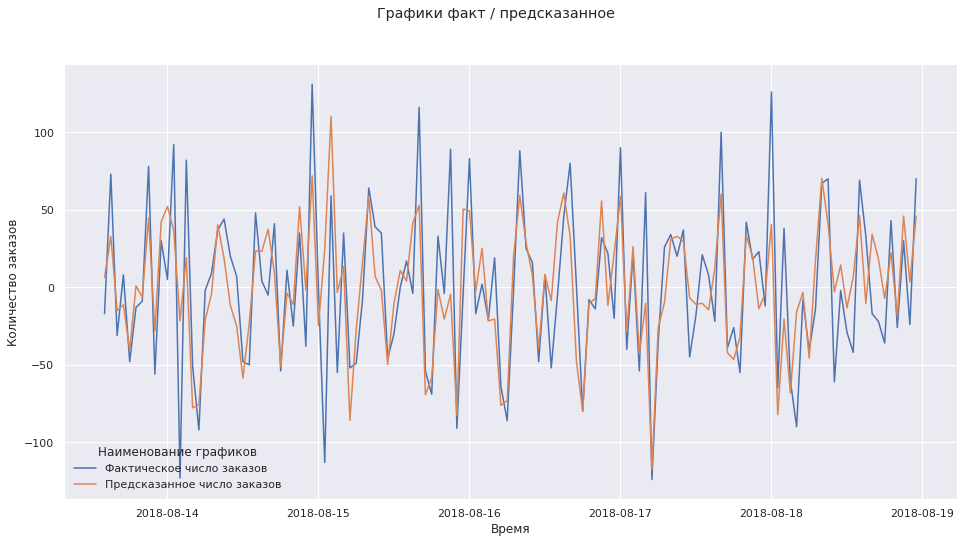

In [ ]:
x = target_test['2018-08-13 14':'2018-08-18'].index
y1 = target_test['2018-08-13 14':'2018-08-18']
y2 = predicted_test[0 : 130]
fig=plt.figure(figsize = (16, 8))
plt.plot(x, y1, label="Фактическое число заказов")
plt.plot(x, y2, label="Предсказанное число заказов")
plt.legend(loc="lower left", title="Наименование графиков", frameon=False)

plt.suptitle('Графики факт / предсказанное')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

# **Выводы**

- Мы подготовили данные для прогнозирования времянных рядов
- Создали признаки для временных рядов
- Обучили модели на основе временных рядов
- Выбрали модель Линейная регрессия предсказания на тестовых данных с хорошей метрикой RMSE - 40
- Судя по построенному графику модель  - адекватная